# King County Housing Sales Project

# Overview

For this project, we use a multiple linear regression model to analyze house sales in King County, a large county located in the State of Washington. Within the notebook, you will see how we iterate upon the data and come to our final model.

# Business Problem

Seattle Real Estate Investment Holdings needs consultation on identifying price dislocation in Washington King County based on certain housing features. To examine pricing in the area we are analyzing recent sales data (2021 - 2022) through creating a multiple linear regression model to explain a percent of the variance in housing price.

# Data Understanding

This project uses the King County House Sales dataset, which can be found in kc_house_data.csv in the data folder of this project's GitHub repository. The description of the column names can be found in column_names.md in the same folder. The dataset was pulled from 

## IMPORTS AND DATA

In [164]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [165]:
sns.set_theme()
sns.set_palette('colorblind')

### Reading the csv into a DataFrame

In [166]:
houses = pd.read_csv('data/kc_house_data.csv')

In [167]:
display(houses.head())
display(houses.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

None

## Initital comments on the Dataframe
- We can see that heat_source and sewer_system have null values, initial thoughts were to remove the nulls associated with these rows. As we further investigate below we realized that this would not be necessary as they will be removed regardless.
- We can also see that there are eight possible catagorical variables that we can dummy out to investigate in our linear regression.

## Feature Engineering 

### Created three different functions to parse out the city, state, and zipcode from the address column

In [168]:
def city(address):
    """
    A function that takes the entry in the 'address' column, which is a string, and
    returns the city in a string.
    """
    address_list = address.split(',')
    if len(address_list) == 6:
        city = address_list[3].strip()
    elif len(address_list) == 5:
        city = address_list[2].strip()
    else:
        city = address_list[1].strip()
    return city

def state(address):
    """
    A function that takes the entry in the 'address' column, which is a string, and
    returns the state in a string.
    """
    address_list = address.split(',')
    if len(address_list) == 6:
        statezip = address_list[4].split()
    elif len(address_list) == 5:
        statezip = address_list[3].split()
    else:
        statezip = address_list[2].split()
        
    if len(statezip) > 2:
        state = statezip[0] + ' ' + statezip[1]
    else:
        state = statezip[0]
    return state

def zipcode(address):
    """
    A function that takes the entry in the 'address' column, which is a string, and
    returns the zipcode in a string.
    """
    address_list = address.split(',')
    zipcode = address_list[-2].split()[-1]
    return zipcode

We're applying the above functions to the Dataframe via a .map and creating a new column for
each respective category. 

The new columns are: city, zipcode, and state.

In [169]:
houses['city'] = houses['address'].map(city)
houses['zipcode'] = houses['address'].map(zipcode)
houses['state'] = houses['address'].map(state)

### Adding a yr_sold column
We first changed the dates in the 'date' column to the format of datetime and then createda new column for year sold from the newly formated 'date' column.

In [170]:
"""
Changing date to datetime and then creating a separate column for year
"""
houses['date'] = pd.to_datetime(houses['date'], infer_datetime_format=True)

"""
Making a 'yr_sold' column using the year from 'date'
"""
houses['yr_sold'] = pd.to_datetime(houses['date'], infer_datetime_format=True).dt.year

# Observations about Correlations between variables

- Below you can observe that 'sqft_living' has the highest correlation with 'price' at 0.61. Based on this we will have our first baseline simple linear regression be between 'price and 'sqft_living'.
- Another observation below is that all the 'sqft_' seem to be highly correlated which can cause us multicollinearity. Before dropping any variables, we are going to run all of them as a regression with 'price' to see how high their R^2 are independently.

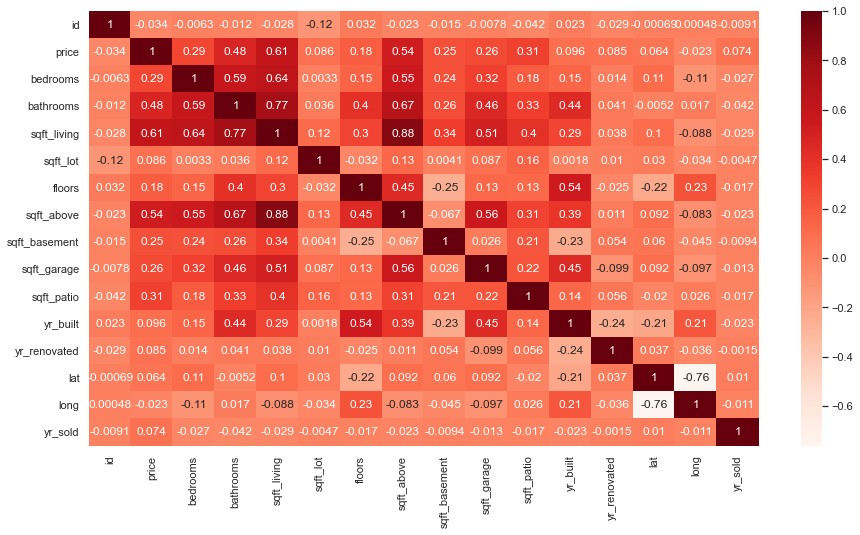

In [171]:
"""
Looking at the correlation between all variables to see which ones have the strongest corr
with variable 'price' using seaborn to heatmap the .corr() method.
"""

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(houses.corr(), cmap='Reds', annot=True);

# Data Cleaning

- After checking the value_counts() for state, we've realized that there are many states besides Washington. Since our focus is just in Washington, we've decided to remove any other state that is not Washington.
- Then we wanted to make sure that we did not have any duplicate values, so we checked our 'id'. Upon further review we realized that we had exactly one duplicate and decided to remove it.

In [172]:
houses.shape

(30155, 29)

In [173]:
houses['state'].value_counts()

Washington        29245
Nebraska            159
New Jersey           79
California           77
New York             66
Minnesota            64
Missouri             61
Wisconsin            51
Illinois             36
Pennsylvania         34
Massachusetts        30
Indiana              30
Oregon               29
Colorado             28
Ohio                 27
North Dakota         21
Florida              18
Iowa                 18
Texas                12
Kansas               11
Michigan              8
Arizona               8
Alaska                7
West Virginia         6
Montana               5
South Carolina        5
Utah                  4
Louisiana             3
Rhode Island          3
Hawaii                2
Idaho                 2
Oklahoma              2
Arkansas              1
Nevada                1
New Mexico            1
Maryland              1
Name: state, dtype: int64

In [174]:
# .duplicated returns the second instance that happens - that is why there is only one entry as the output
houses.loc[houses.duplicated(subset=['id'])]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_patio,yr_built,yr_renovated,address,lat,long,city,zipcode,state,yr_sold
4846,1233100736,2021-09-28,2600000.0,3,4.0,3500,8455,2.0,NO,NO,...,290,2019,0,"12611 Northeast 87th Place, Kirkland, Washingt...",47.68069,-122.172135,Kirkland,98033,Washington,2021


In [175]:
# dropping other states, duplicate id, and the 30,750,000.00 dollar house
houses = houses.loc[houses['state'] == 'Washington']
houses.drop_duplicates(subset=['id'], inplace=True)

In [176]:
#sanity check
display(houses['state'].value_counts())
display(houses.loc[houses['id'] == 1233100736])

Washington    29244
Name: state, dtype: int64

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_patio,yr_built,yr_renovated,address,lat,long,city,zipcode,state,yr_sold
4845,1233100736,2021-09-28,2600000.0,3,4.0,3500,8455,2.0,NO,NO,...,290,2019,0,"12611 Northeast 87th Place, Kirkland, Washingt...",47.68069,-122.172135,Kirkland,98033,Washington,2021


### Creating a function to list out all R^2 of interest

In [177]:
def Rsquaredcomp(dataframe,target_str,comp_list):
    """
    This is a function that returns a dataframe which lists
    all the R^2 for all the chosen variables.
    
    dataframe -> the dataframe that will be used to run the regression
    
    target_str -> the string name of the target variable/column to be predicted
    
    comp_list -> a list of strings of the variables/columns that will be individually
                    used to predict 'price'.
    """
    Rsquared = []
    for i in comp_list:
        y = dataframe[target_str]
        X = dataframe[i]
        simple_model = sm.OLS(endog=y, exog=sm.add_constant(X))
        simple_model_results = simple_model.fit()
        r2 = simple_model_results.rsquared
        Rsquared.append(r2)
    
    df = pd.DataFrame(np.array(Rsquared),index=comp_list,columns=["Rsquared"])
    return df

Running the function above to clearly compare which of the numeric variables have the
highest R^2.

In [178]:
comp = ['floors','bedrooms','bathrooms','floors','sqft_living', 'sqft_above','sqft_basement',
        'sqft_garage','sqft_patio', 'sqft_lot',
        'yr_built', 'yr_renovated','lat','long']
Rsquaredcomp(houses,'price',comp)

,Rsquared
floors,0.039654
bedrooms,0.084849
bathrooms,0.238156
floors,0.039654
sqft_living,0.380203
sqft_above,0.298243
sqft_basement,0.060771
sqft_garage,0.071796
sqft_patio,0.100619
sqft_lot,0.007393


# Simple Regression (Baseline)
We will explore our target (price) with the variable with the strongest correlation which is sqft_living

In [179]:
# setting our alpha
alpha = 0.05

In [180]:
y = houses['price']
X = houses[['sqft_living']]

base_model = sm.OLS(endog=y, exog=sm.add_constant(X))
base_results = base_model.fit()
base_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.794e+04
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:40:43   Log-Likelihood:            -4.3529e+05
No. Observations:               29244   AIC:                         8.706e+05
Df Residuals:                   29242   BIC:                         8.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.091e+04   9885.550     -9.196      0.000    -1.1e+05   -7.15e+04
sqft_living   564.8352      4.217    133.933      0.000     556.569     573.101
==============================================================================
Omnibus:                    42311.944   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50086865.110
Skew:                           8.231   Prob(JB):                         0.00
Kurtosis:                     205.075   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our base model of housing prices and sqft living gives us a R^2 of .395; this means that sqft living can explain .395 of the variance in housing prices. We know this model is significant becasue p_value for the f-statistic is below our alpha. We can interpret our coefficient for sqft living as: For every unit increase in sqft living, there is an increase on average of $564.93 USD in price. 

### Checking our assumptions
1. linearity
2. Normality
3. Independence 
4. Homoskedasticity

### Llinearity - with statsmodels 
One way to check this is by drawing a scatter plot of your predictions as a function of your residuals. Ideally, we'll see a linear relationship here.

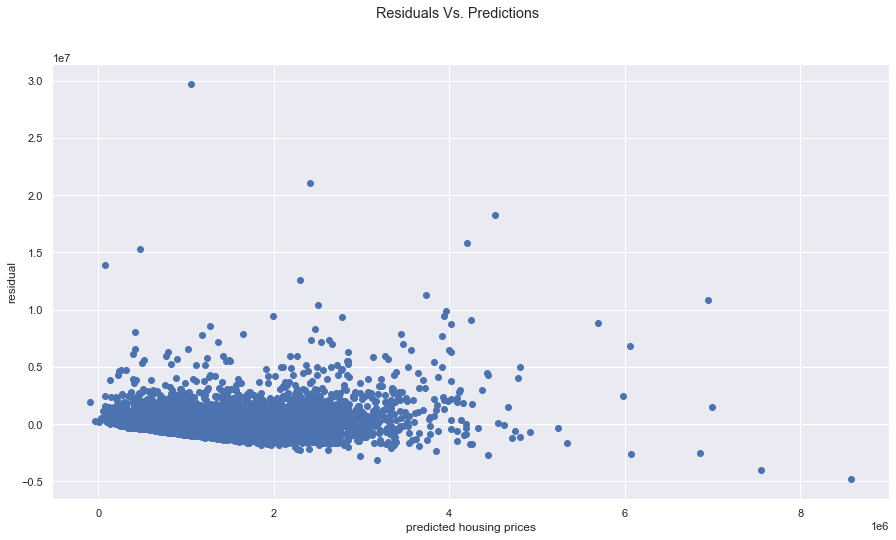

In [181]:
model_preds = base_results.predict(sm.add_constant(X))
# resid = error (differecne from real points (y) to predict points (preds))
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted housing prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');

### Statistical independence of the errors
The errors are independent. In other words: Knowing the error for one point doesn't tell you anything about the error for another. With correlated errors our model will tend to underestimate the errors around our betas, and so we run the risk of false positive conclusions about the significance of variables.

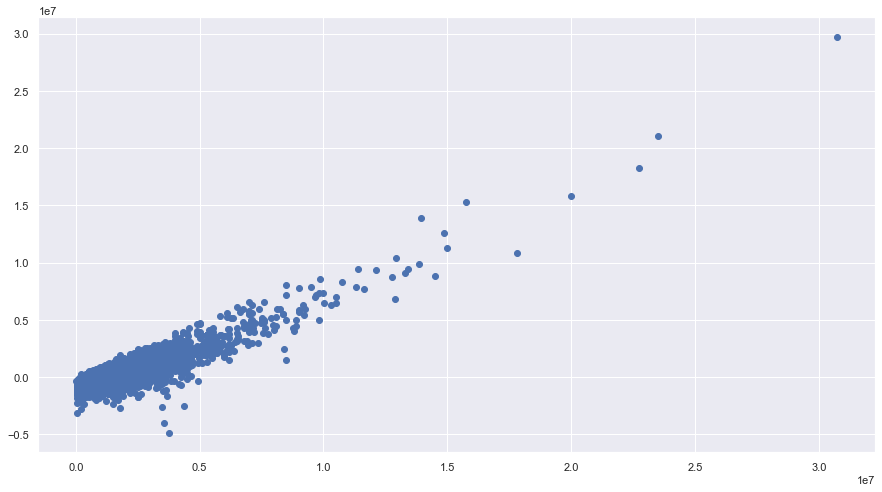

In [182]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

The Durbin-Watson test statistic is calculated on the null hypothesis that there is no correlation among the errors. The test statistic has a range of 0 to 4, where 2 indicates no correlation, a score less than 2 indicates a positive correlation, and a score greater than 2 indicates a negative correlation.

In [183]:
dw = sm.stats.stattools.durbin_watson
dw(resids)

1.9371602371201257

According to the durbin watson statistic above, there is a low positive correlation. It is important to note that it is very close to 2 which means no correlation.

### Normality
The errors are normally distributed. That is, smaller errors are more probable than larger errors, according to the familiar bell curve. This is basically a conseqence of the Central Limit Theorem. If an error is a sum of influences from a large collection of (untracked!) variables, then the CLT assures us that that sum will have a normal distribution, regardless of the distributions of the untracked variables themselves.

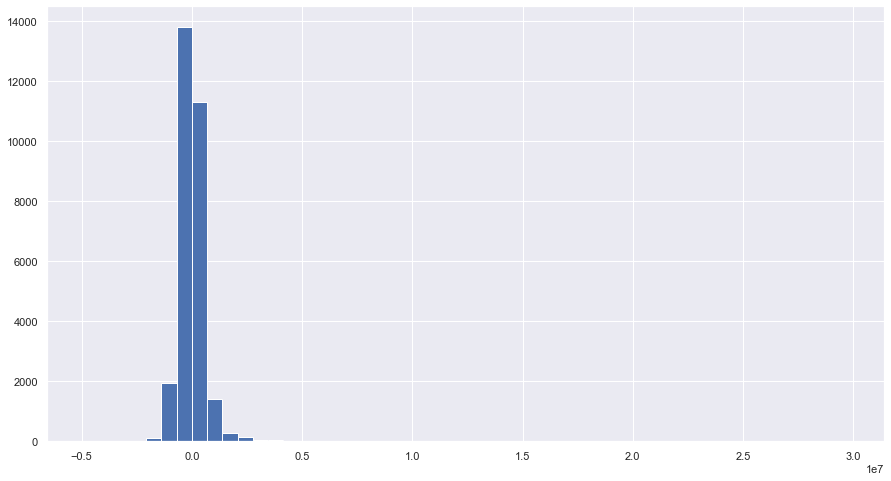

In [184]:
resids.hist(bins=50);

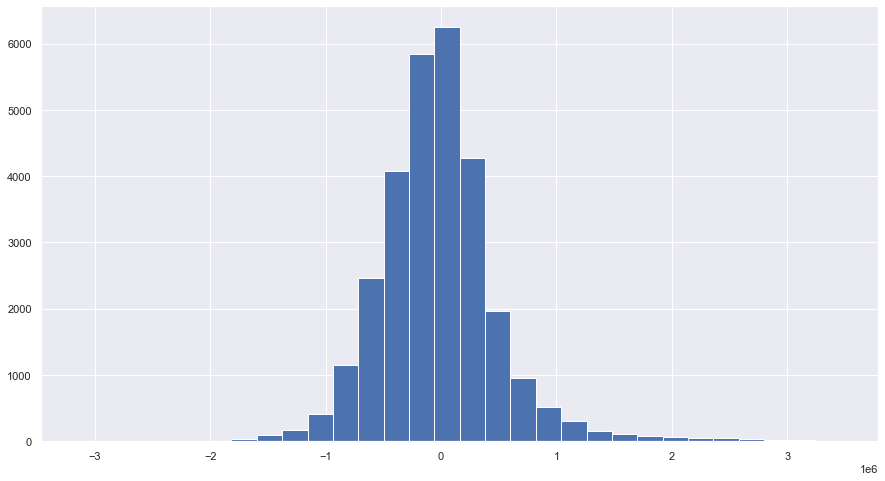

In [185]:
# To eliminate the outliers from the plot we might try zooming in on the center:
resids[abs(resids) < 3500000].hist(bins=30);

In [186]:
#fig, ax = plt.subplots()
#ax.scatter(y_log, resids);

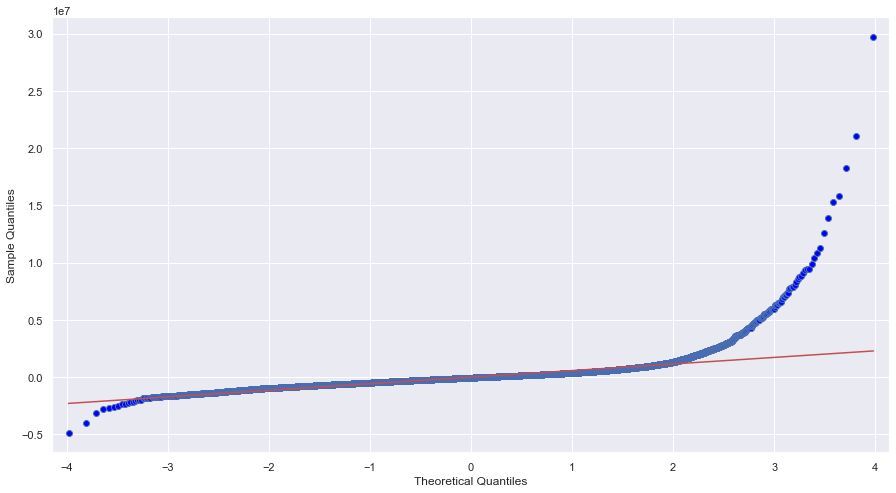

In [187]:
sm.qqplot(resids, line='r');

When the errors are normal, they will follow the diagonal line closely. Here we see some significant divergences, especially on the tails of the line.

The null hypothesis for the Jarque-Bera Test is that errors are normally distributed. Here we have a huge test statistic and tiny p-value. So we have to reject this null hypothesis. Similarly, the statsmodels Omnibus test tests for skewness and kurtosis, and so we are looking for small numbers. But again we see the opposite

In [188]:
base_results.summary().tables[2]

Omnibus:,42311.944,Durbin-Watson:,1.937
Prob(Omnibus):,0.000,Jarque-Bera (JB):,50086865.110
Skew:,8.231,Prob(JB):,0.00
Kurtosis:,205.075,Cond. No.,5.62e+03


### Homoskedasticity

Errors are homoskedatic = the errors have the same variance.
If errors are not homoskedastic, betas will have larger errors, leading to a greater risk of false negative conclusions about the significance of variables.

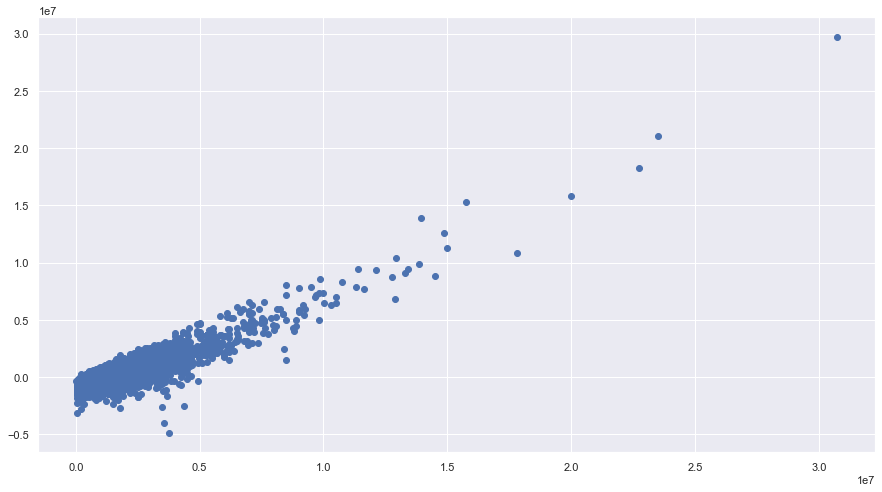

In [189]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

## Transforming our target (price)
Non-normal errors are often the result of non-normal variables. In the present case, we note the exponential distribution of the target itself: We saw from our histogram of price it was very right skewed and so by taking the natural log, we will improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve.

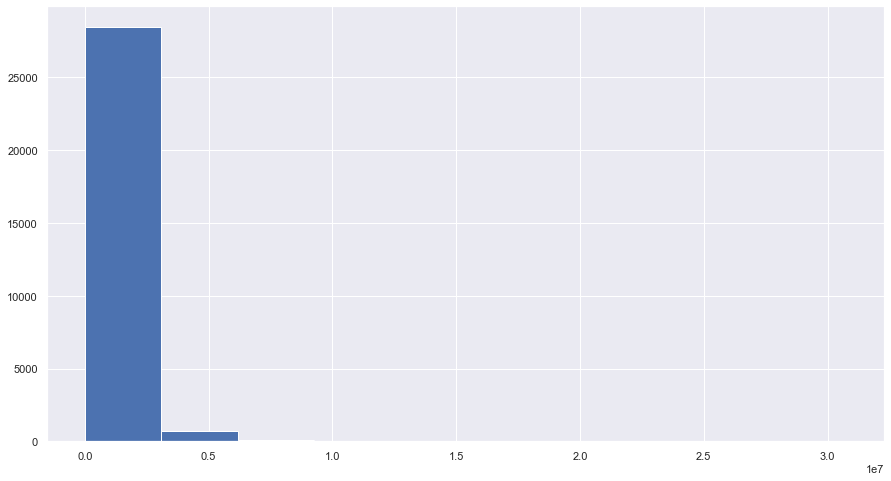

In [190]:
y.hist();

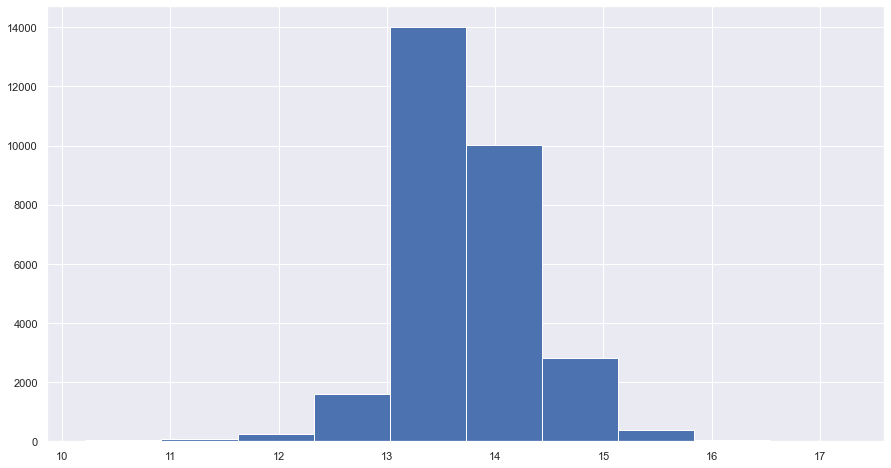

In [191]:
# taking the natural log of prices
y_log = np.log(y)
y_log.hist();

In [192]:
# Improved simple regression (baseline) after transforming our target
X = houses[['sqft_living']]

base_model_scld = sm.OLS(endog=y_log, exog=sm.add_constant(X))
base_results_scld = base_model_scld.fit()
base_results_scld.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                 1.870e+04
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:40:58   Log-Likelihood:                -18636.
No. Observations:               29244   AIC:                         3.728e+04
Df Residuals:                   29242   BIC:                         3.729e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9398      0.006   2015.900      0.000      12.927      12.952
sqft_living     0.0004   2.74e-06    136.741      0.000       0.000       0.000
==============================================================================
Omnibus:                     5809.043   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45229.479
Skew:                          -0.745   Prob(JB):                         0.00
Kurtosis:                       8.907   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [320]:
# Interpretation will no longer be 
print(f"""
A one-unit increase in the sqft corresponds to an increase in price 
by a factor of {round(np.exp(-2.3971), 5)}, or {100 * round(np.exp(-2.3971) - 1, 5)}%.
""")


A one-unit increase in the sqft corresponds to an increase in price 
by a factor of 0.09098, or -90.902%.



# Further exploration of data
- Testing different multi-linear regressions to see which variables we want to keep.
- We ran all the categorical variables with sqft_living and decided that we should only keep 'bedrooms','bathrooms', 'sqft_living','view','grade','zipcode', and 'yr_sold'
    - We're keeping these variables because after we ran the multiple linear regressions with sqft_living they returned the highest increase in R^2.

## Checking the most frequent for variables

In [194]:
display(houses['waterfront'].value_counts())
display(houses['greenbelt'].value_counts())
display(houses['nuisance'].value_counts())
display(houses['view'].value_counts())
display(houses['condition'].value_counts())
display(houses['heat_source'].value_counts())
display(houses['sewer_system'].value_counts())

NO     28728
YES      516
Name: waterfront, dtype: int64

NO     28474
YES      770
Name: greenbelt, dtype: int64

NO     24225
YES     5019
Name: nuisance, dtype: int64

NONE         25711
AVERAGE       1896
GOOD           870
EXCELLENT      552
FAIR           215
Name: view, dtype: int64

Average      17644
Good          8048
Very Good     3259
Fair           229
Poor            64
Name: condition, dtype: int64

Gas                  20175
Electricity           5966
Oil                   2899
Gas/Solar               93
Electricity/Solar       57
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

PUBLIC                24872
PRIVATE                4351
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         2
Name: sewer_system, dtype: int64

## MLR with waterfront and sqft living

In [195]:
# making a dataframe with column of interest dummied out
cat_water_df = houses[['price','sqft_living','waterfront']]
cat_water_df = pd.get_dummies(cat_water_df,columns=['waterfront'])


# Dropping the most frequent (waterfront_NO)
cat_water_df.drop(columns=['waterfront_NO','price'],axis=1,inplace=True)

testwater_model = sm.OLS(endog=y, exog=sm.add_constant(cat_water_df))
testwater_results = testwater_model.fit()
testwater_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                 1.041e+04
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:41:24   Log-Likelihood:            -4.3442e+05
No. Observations:               29244   AIC:                         8.688e+05
Df Residuals:                   29241   BIC:                         8.689e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.473e+04   9597.177     -8.828      0.000   -1.04e+05   -6.59e+04
sqft_living      551.2464      4.106    134.242      0.000     543.198     559.295
waterfront_YES   1.29e+06   3.05e+04     42.331      0.000    1.23e+06    1.35e+06
==============================================================================
Omnibus:                    40086.101   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         41540692.434
Skew:                           7.398   Prob(JB):                         0.00
Kurtosis:                     187.046   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [202]:
# making a dataframe with column of interest dummied out
cat_view_df = houses[['price','sqft_living','view']]
cat_view_df = pd.get_dummies(cat_view_df,columns=['view'])


# Dropping the most frequent (view_NONE)
cat_view_df.drop(columns=['view_NONE','price'],axis=1,inplace=True)

testview_model = sm.OLS(endog=y, exog=sm.add_constant(cat_view_df))
testview_results = testview_model.fit()
testview_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     4366.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:43:31   Log-Likelihood:            -4.3413e+05
No. Observations:               29244   AIC:                         8.683e+05
Df Residuals:                   29238   BIC:                         8.683e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.077e+04   9546.953     -5.318      0.000   -6.95e+04   -3.21e+04
sqft_living      522.6243      4.179    125.067      0.000     514.434     530.815
view_AVERAGE    1.903e+05   1.62e+04     11.716      0.000    1.58e+05    2.22e+05
view_EXCELLENT  1.384e+06   2.95e+04     46.860      0.000    1.33e+06    1.44e+06
view_FAIR       4.196e+05   4.65e+04      9.031      0.000    3.29e+05    5.11e+05
view_GOOD       2.776e+05   2.36e+04     11.753      0.000    2.31e+05    3.24e+05
==============================================================================
Omnibus:                    40685.454   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44752045.612
Skew:                           7.607   Prob(JB):                         0.00
Kurtosis:                     194.039   Cond. No.                     2.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## MLR with greenbelt and sqft living

In [ ]:
# making a dataframe with column of interest dummied out
cat_green_df = houses[['price','sqft_living','view']]
cat_green_df = pd.get_dummies(cat_green_df,columns=['view'])


# Dropping the most frequent (view_NO)
cat_view_df.drop(columns=['view_NO','price'],axis=1,inplace=True)

testview_model = sm.OLS(endog=y, exog=sm.add_constant(cat_view_df))
testview_results = testview_model.fit()
testview_results.summary()

## MLR with view and sqft living

In [205]:
# making a dataframe with column of interest dummied out
cat_view_df = houses[['price','sqft_living','view']]
cat_view_df = pd.get_dummies(cat_view_df,columns=['view'])


# Dropping the most frequent (view_NONE)
cat_view_df.drop(columns=['view_NONE','price'],axis=1,inplace=True)

testview_model = sm.OLS(endog=y, exog=sm.add_constant(cat_view_df))
testview_results = testview_model.fit()
testview_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     4366.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:44:22   Log-Likelihood:            -4.3413e+05
No. Observations:               29244   AIC:                         8.683e+05
Df Residuals:                   29238   BIC:                         8.683e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.077e+04   9546.953     -5.318      0.000   -6.95e+04   -3.21e+04
sqft_living      522.6243      4.179    125.067      0.000     514.434     530.815
view_AVERAGE    1.903e+05   1.62e+04     11.716      0.000    1.58e+05    2.22e+05
view_EXCELLENT  1.384e+06   2.95e+04     46.860      0.000    1.33e+06    1.44e+06
view_FAIR       4.196e+05   4.65e+04      9.031      0.000    3.29e+05    5.11e+05
view_GOOD       2.776e+05   2.36e+04     11.753      0.000    2.31e+05    3.24e+05
==============================================================================
Omnibus:                    40685.454   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44752045.612
Skew:                           7.607   Prob(JB):                         0.00
Kurtosis:                     194.039   Cond. No.                     2.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## MLR with view and sqft living

## MLR with grade and sqft living

In [ ]:
# finding the median price of houses for each grade

houses.groupby('grade').median()['price'].sort_values()

Decided to drop grade 13 Mansion with the highest median price as the comparison group for grade.

In [ ]:
# making a dataframe with column of interest dummied out
cat_grd_df = clean_houses[['price','sqft_living','grade']]
cat_grd_df = pd.get_dummies(cat_grd_df,columns=[‘grade’])


# Dropping grade with the highest median price
cat_grd_df.drop(columns=['grade_13 Mansion','price'],axis=1,inplace=True)

testgrade_model = sm.OLS(endog=y, exog=sm.add_constant(cat_grd_df))
testgrade_results = testgrade_model.fit()
testgrade_results.summary()

## MLR with zipcode and sqft living

In [ ]:
# finding the median price of houses for each zipcode

houses.groupby('zipcode').median()['price'].sort_values()

In [ ]:
pd.options.display.float_format = '{:30,.2f}'.format

In [ ]:
# making a dataframe with column of interest dummied out
cat_zip_df = clean_houses[['price','sqft_living','zipcode']]
cat_zip_df = pd.get_dummies(cat_zip_df,columns=['zipcode'])

# dropping the zipcode with the highest median price
cat_zip_df.drop(columns=['zipcode_98039','price'],axis=1,inplace=True)

testzip_model = sm.OLS(endog=y_log, exog=sm.add_constant(cat_zip_df))
testzip_results = testzip_model.fit()
testzip_results.summary()

## Dropping the columns we don't need

In [206]:
# Dropping columns with R^2 that increased the baseline the least.
clean_houses = houses.drop(columns=['date','sqft_above','sqft_basement','sqft_garage','sqft_patio',
                                              'sqft_lot','waterfront','greenbelt','nuisance','condition',
                                              'heat_source','sewer_system','state','yr_built',
                                              'yr_renovated','address','lat','long','floors', 'city'])

# Dropping grade 1 Cabin because as seen in the groupby price above, it is a misleading category
clean_houses = clean_houses.loc[clean_houses['grade'] != "1 Cabin"]

In [207]:
clean_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29242 entries, 0 to 30154
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           29242 non-null  int64  
 1   price        29242 non-null  float64
 2   bedrooms     29242 non-null  int64  
 3   bathrooms    29242 non-null  float64
 4   sqft_living  29242 non-null  int64  
 5   view         29242 non-null  object 
 6   grade        29242 non-null  object 
 7   zipcode      29242 non-null  object 
 8   yr_sold      29242 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 2.2+ MB


In [208]:
#Reseting the y and x, so that these arrays are most up to date and there are no shape
# mismatches.
y = clean_houses['price']
X = clean_houses[['sqft_living']]
y_log = np.log(y)

In [209]:
"""
Creating a new dataframe with all of our categorical variables getting dummies, so that
we can run a regression.
"""
cat_df = pd.get_dummies(clean_houses,columns=['view','grade','zipcode'])

In [210]:
#Sanity Check
#cat_df

In [211]:
"""
Dropping the dummies that we want to compare to.

grade_13 Mansion: construction material grade with the highest median sales price
zipcode_98039: zipcode with the highest median sales price
view_NONE: most common view type
"""
cat_df.drop(columns=['view_NONE', 'grade_13 Mansion', 'zipcode_98039'], inplace=True)

In [212]:
#Sanity Check
#list(cat_df.columns)

In [213]:
"""
Talking about next steps, bar graph of yr sold as supporting visual.
Subset 2021 2022, avg sale price
Then subset into the zipcodes

"""

'\nTalking about next steps, bar graph of yr sold as supporting visual.\nSubset 2021 2022, avg sale price\nThen subset into the zipcodes\n\n'

# Final Multiple Linear Regression model

In [223]:
X_final = cat_df.drop(columns=['id', 'price', 'yr_sold'])
X_final

,bedrooms,bathrooms,sqft_living,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,...,zipcode_98338,zipcode_98354,zipcode_98372,zipcode_98387,zipcode_98422,zipcode_98663,zipcode_99202,zipcode_99203,zipcode_99223,zipcode_99403
0,4,1.0,1180,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,2.5,2770,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,2.0,2880,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3.0,2160,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2.0,1120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,5,2.0,1910,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30151,3,2.0,2020,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30152,3,2.0,1620,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30153,3,2.5,2570,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We are sclaing our X_final 

In [224]:
scaler = StandardScaler()

In [225]:
scaler.fit(X_final)

StandardScaler()

In [226]:
X_final_scld = scaler.transform(X_final)
X_final_scld

array([[ 0.57721928, -1.48761879, -0.97290625, ..., -0.00584795,
        -0.00584795, -0.00584795],
       [ 1.5989533 ,  0.18729838,  0.65418899, ..., -0.00584795,
        -0.00584795, -0.00584795],
       [ 2.62068732, -0.37100734,  0.76675533, ..., -0.00584795,
        -0.00584795, -0.00584795],
       ...,
       [-0.44451475, -0.37100734, -0.5226409 , ..., -0.00584795,
        -0.00584795, -0.00584795],
       [-0.44451475,  0.18729838,  0.44952293, ..., -0.00584795,
        -0.00584795, -0.00584795],
       [-0.44451475, -0.92931307, -0.95243964, ..., -0.00584795,
        -0.00584795, -0.00584795]])

In [311]:
final_model = sm.OLS(endog=y_log, exog=sm.add_constant(X_final))
final_results = final_model.fit()
final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     600.0
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:57:08   Log-Likelihood:                -8649.2
No. Observations:               29242   AIC:                         1.752e+04
Df Residuals:                   29132   BIC:                         1.843e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  14.3680      0.083    173.426      0.000      14.206      14.530
bedrooms                0.0068      0.003      2.460      0.014       0.001       0.012
bathrooms               0.0184      0.004      5.041      0.000       0.011       0.026
sqft_living             0.0002   4.25e-06     46.512      0.000       0.000       0.000
view_AVERAGE            0.1170      0.008     14.588      0.000       0.101       0.133
view_EXCELLENT          0.4618      0.015     31.575      0.000       0.433       0.491
view_FAIR               0.1663      0.023      7.371      0.000       0.122       0.211
view_GOOD               0.1751      0.012     15.039      0.000       0.152       0.198
grade_10 Very Good      0.1442      0.069      2.086      0.037       0.009       0.280
grade_11 Excellent      0.2239      0.070      3.205      0.001       0.087       0.361
grade_12 Luxury         0.1635      0.073      2.225      0.026       0.019       0.307
grade_2 Substandard    -0.8242      0.242     -3.411      0.001      -1.298      -0.351
grade_3 Poor           -0.5671      0.115     -4.928      0.000      -0.793      -0.342
grade_4 Low            -0.2477      0.085     -2.928      0.003      -0.414      -0.082
grade_5 Fair           -0.2383      0.073     -3.271      0.001      -0.381      -0.096
grade_6 Low Average    -0.1968      0.071     -2.771      0.006      -0.336      -0.058
grade_7 Average        -0.1280      0.070     -1.819      0.069      -0.266       0.010
grade_8 Good           -0.0408      0.070     -0.585      0.559      -0.178       0.096
grade_9 Better          0.0878      0.069      1.265      0.206      -0.048       0.224
zipcode_98001          -1.4773      0.045    -33.024      0.000      -1.565      -1.390
zipcode_98002          -1.5583      0.046    -33.761      0.000      -1.649      -1.468
zipcode_98003          -1.5121      0.046    -33.216      0.000      -1.601      -1.423
zipcode_98004          -0.2926      0.046     -6.328      0.000      -0.383      -0.202
zipcode_98005          -0.5673      0.049    -11.559      0.000      -0.663      -0.471
zipcode_98006          -0.7502      0.045    -16.703      0.000      -0.838      -0.662
zipcode_98007          -0.7306      0.050    -14.556      0.000      -0.829      -0.632
zipcode_98008          -0.7054      0.046    -15.409      0.000      -0.795      -0.616
zipcode_98010          -1.3640      0.047    -29.317      0.000      -1.455      -1.273
zipcode_98011          -0.9276      0.047    -19.628      0.000      -1.020      -0.835
zipcode_98014          -1.1645      0.050    -23.305      0.000      -1.262      -1.067
zipcode_98019          -1.1214      0.048    -23.589      0.000      -1.215      -1.028
zipcode_98022          -1.4505      0.045    -31.933      0.000      -1.540      -1.362
zip

In [312]:
np.exp(.0002)

1.0002000200013335

## Checking our 4 Assumptions

### Linearity

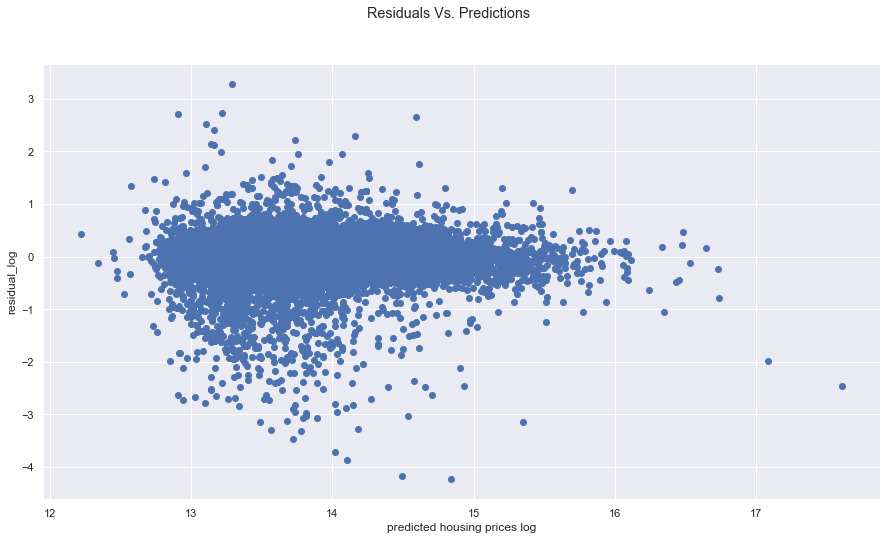

In [231]:
final_model_preds = final_results.predict(sm.add_constant(X_final_scld))

# resid = error (differecne from real points (y) to predict points (preds))
final_resids = y_log - final_model_preds

fig, ax = plt.subplots()

ax.scatter(final_model_preds, final_resids)
ax.set_xlabel('predicted housing prices log')
ax.set_ylabel('residual_log')
plt.suptitle('Residuals Vs. Predictions');

#Negative means overestimating, diff between actual and pred
#Positive means underestimating,

### Independence

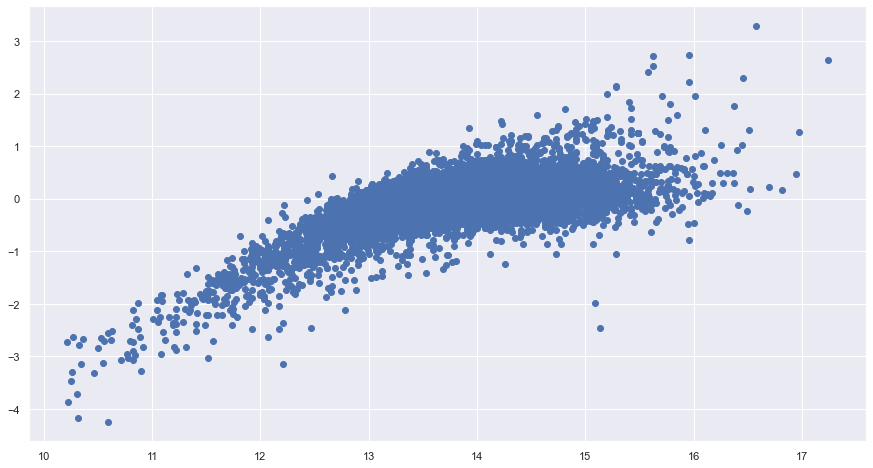

In [232]:
fig, ax = plt.subplots()

ax.scatter(y_log, final_resids);

The Durbin-Watson test statistic is calculated on the null hypothesis that there is no correlation among the errors. The test statistic has a range of 0 to 4, where 2 indicates no correlation, a score less than 2 indicates a positive correlation, and a score greater than 2 indicates a negative correlation.

In [233]:
# Checking Durbin-Watson test statistic
dw = sm.stats.stattools.durbin_watson
dw(final_resids)

1.965828052069355

The Durbin-Watson test statistic came back even closer to 2 compared to the DW statistic from our baseline model. 

### Normality

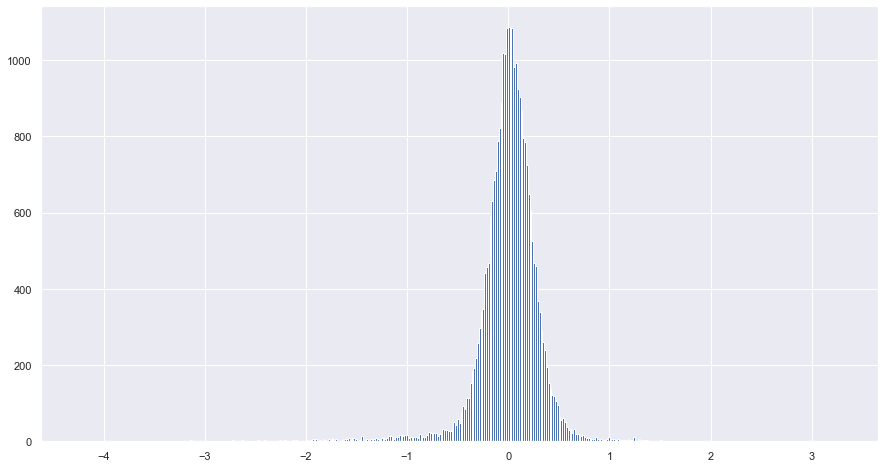

In [234]:
final_resids.hist(bins='auto');

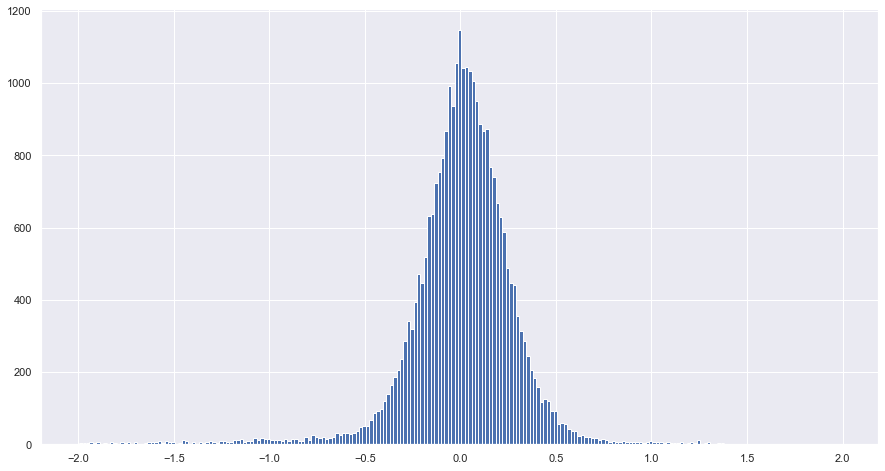

In [235]:
# To eliminate the outliers from the plot we might try zooming in on the center:
final_resids[abs(final_resids) < 2].hist(bins='auto');

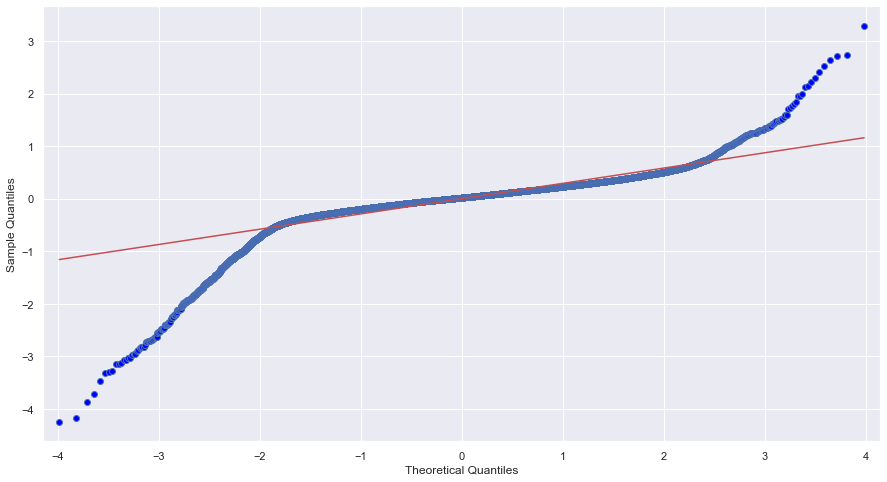

In [236]:
sm.qqplot(final_resids, line='r');

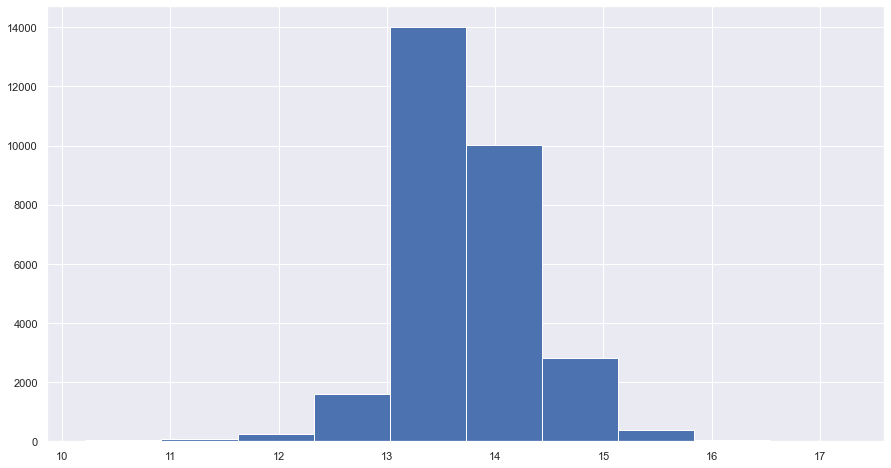

In [237]:
y_log.hist();

### Homoskedasticity
We made a scatter plot of the residuals and target values and look to see if they are more or less spread out at different places

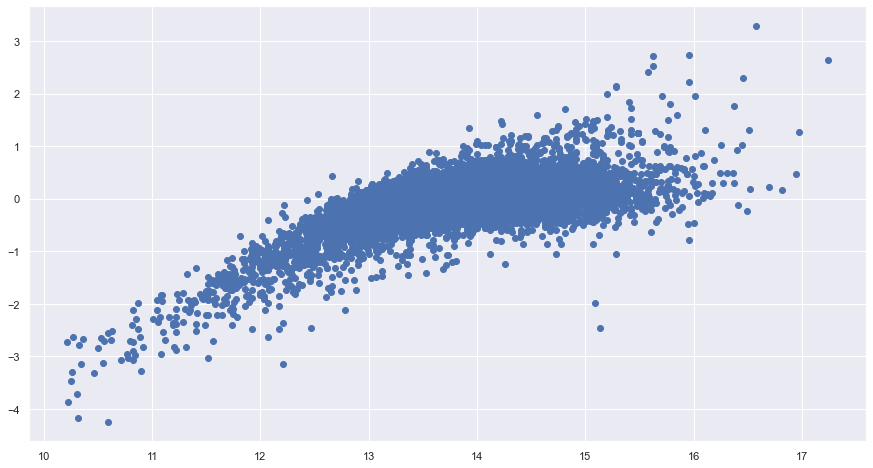

In [99]:
fig, ax = plt.subplots()
ax.scatter(y_log, final_resids);

We can see our model is homoskedastic between the ranges of 13 and 16. For the lower priced houses we are over estimating and for the higher priced houses we are under-estimating the prices with our model. 

In [ ]:
# for model slide, y_pred vs y_actual

## Interpreting our coeficients for our final MLR

In [238]:
# getting the p_value for each coeficients 
p_value = []
for x in range (0, 110):
    p_value.append(final_results.pvalues[x])

p_value

[0.0,
 0.01391255543829354,
 4.648567504584467e-07,
 0.0,
 4.9179237530562786e-48,
 3.453026721714375e-215,
 1.732882314209081e-13,
 6.349020362628958e-51,
 0.03698720625491304,
 0.0013512965195685255,
 0.026057378011220697,
 0.0006479049243004597,
 8.33184439144945e-07,
 0.003411417277102654,
 0.0010726300347066134,
 0.005594414563860715,
 0.0689841208250421,
 0.5587145299163894,
 0.20590725772029003,
 7.990473466980571e-235,
 4.0006339098533e-245,
 1.716966927838089e-237,
 2.515895350038512e-10,
 7.784650453485242e-31,
 2.4315955240409295e-62,
 7.839324053142166e-48,
 2.3009835930877986e-53,
 3.192371481469051e-186,
 3.189768962263305e-85,
 4.8852482984222026e-119,
 6.957574562511005e-122,
 5.778930693943594e-220,
 6.355755171968864e-245,
 4.7272803832722384e-65,
 5.405622915702232e-88,
 3.598136469505301e-107,
 2.3770682043709644e-67,
 5.059104456189085e-215,
 6.894227997480652e-219,
 8.161674641103025e-191,
 7.241338101375587e-33,
 3.3663360004900546e-76,
 4.2135104706066975e-181,


In [239]:
final_results.params

const    13.737661
x1        0.006643
x2        0.016496
x3        0.193392
x4        0.028797
           ...    
x105     -0.010556
x106     -0.006073
x107     -0.006387
x108     -0.005944
x109     -0.006182
Length: 110, dtype: float64

In [240]:
mlr_stats = pd.DataFrame(final_results.params, columns=['coef'])
mlr_stats

,coef
const,13.737661
x1,0.006643
x2,0.016496
x3,0.193392
x4,0.028797
...,...
x105,-0.010556
x106,-0.006073
x107,-0.006387
x108,-0.005944


In [241]:
mlr_stats['p_value'] = p_value

In [242]:
mlr_stats.reset_index(inplace=True)

In [243]:
mlr_stats['stat_sig']= mlr_stats['p_value'] < 0.05

For every one-unit increase in the independent variable, our dependent variable increases by about (coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9) 22%.

For every unit increase in sqft living, our price will increase by about 


In [ ]:
#while mlr_stats.index <5:
 #   for i in mlr_stats['index']:
  #      print(i)
    # print(f'For every unit increase in {mlr_stats.index[0:5]})

In [244]:
mlr_stats

,index,coef,p_value,stat_sig
0,const,13.737661,0.000000e+00,True
1,x1,0.006643,1.391256e-02,True
2,x2,0.016496,4.648568e-07,True
3,x3,0.193392,0.000000e+00,True
4,x4,0.028797,4.917924e-48,True
...,...,...,...,...
105,x105,-0.010556,5.243848e-08,True
106,x106,-0.006073,1.583507e-03,True
107,x107,-0.006387,8.914540e-04,True
108,x108,-0.005944,1.986165e-03,True


- sqft living
- zipcode (top 10 most negative coef)



# Final Model Visualization

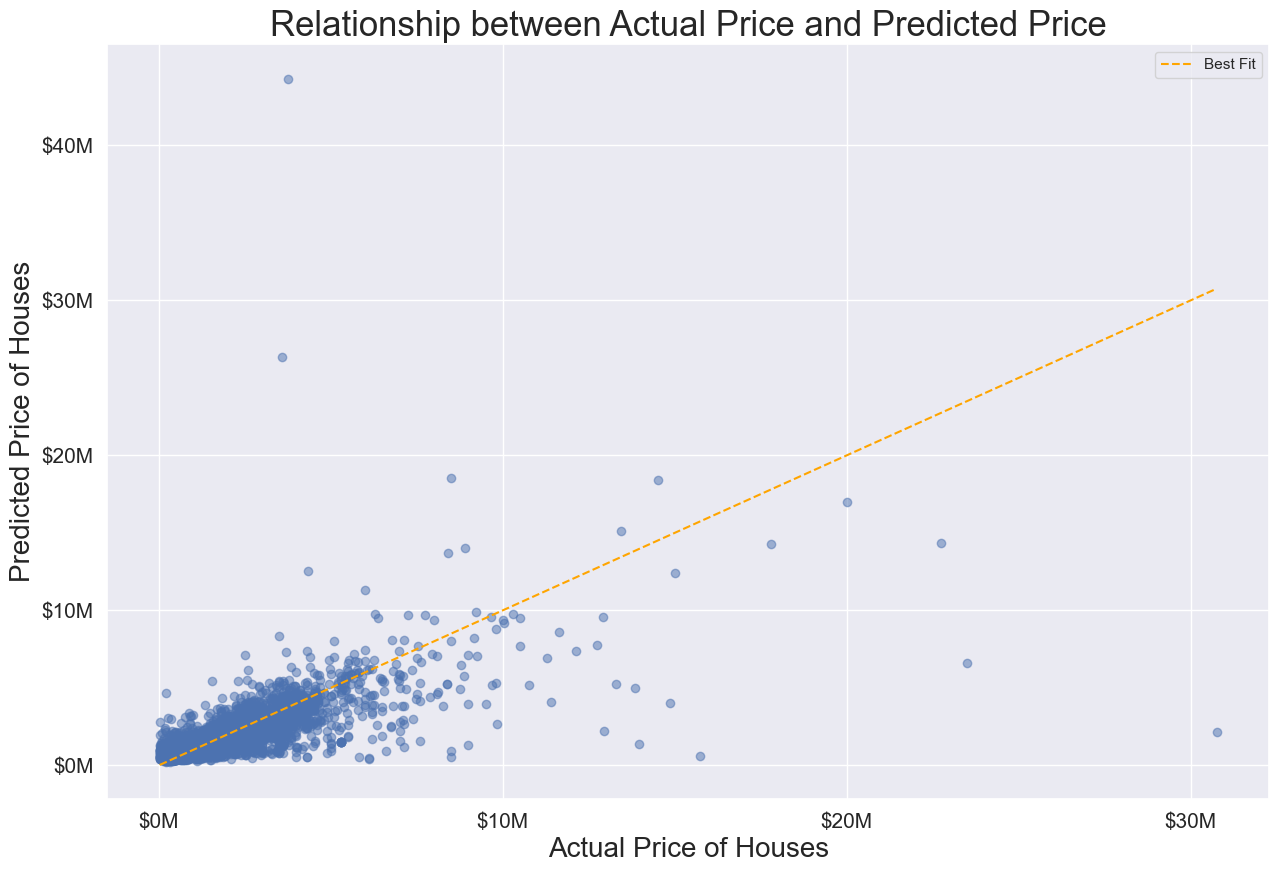

In [310]:
y = np.exp(final_results.predict(sm.add_constant(X_final_scld)))

# setting up line
line = np.arange(cat_df['price'].min(), cat_df['price'].max())

# setting up graph
fig, ax = plt.subplots(figsize=(15,10), dpi=100)

ax.plot(line, line, linestyle="--", color="orange", label="Best Fit")
ax.scatter(cat_df['price'], y, alpha=0.5)

_y_ticks = [(value * 10**7) for value in range(0,5,1)]
_x_ticks = [(value * 10**7) for value in range(0,4,1)]
ax.set(
    yticks=_y_ticks, 
    xticks = _x_ticks,
    yticklabels = [f'${int(x/1000000):,}M' for x in _y_ticks],
    xticklabels = [f'${int(x/1000000):,}M' for x in _x_ticks]
)
ax.legend()
plt.title("Relationship between Actual Price and Predicted Price", fontsize=25)
plt.xlabel("Actual Price of Houses", fontsize=20)
plt.ylabel("Predicted Price of Houses", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('images/model_fig.png')

plt.show()

# Visualizations for our three interpretations

We chose to focus our interpretations on sqft living, grade of construction material, and zipcodes.

## SQFT living Visualization

In [282]:
scaled_df = pd.DataFrame(X_final_scld)
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,0.577219,-1.487619,-0.972906,-0.263239,-0.138709,-0.086063,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848
1,1.598953,0.187298,0.654189,3.798833,-0.138709,-0.086063,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848
2,2.620687,-0.371007,0.766755,3.798833,-0.138709,-0.086063,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848
3,-0.444515,0.745604,0.029957,3.798833,-0.138709,-0.086063,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848
4,-1.466249,-0.371007,-1.034306,-0.263239,-0.138709,-0.086063,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29237,1.598953,-0.371007,-0.225875,-0.263239,-0.138709,-0.086063,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848
29238,-0.444515,-0.371007,-0.113309,-0.263239,-0.138709,11.619350,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848
29239,-0.444515,-0.371007,-0.522641,-0.263239,-0.138709,-0.086063,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848
29240,-0.444515,0.187298,0.449523,-0.263239,-0.138709,-0.086063,-0.175111,-0.220173,-0.118063,-0.064727,...,-0.00827,-0.028056,-0.00827,-0.00827,-0.005848,-0.00827,-0.005848,-0.005848,-0.005848,-0.005848


''

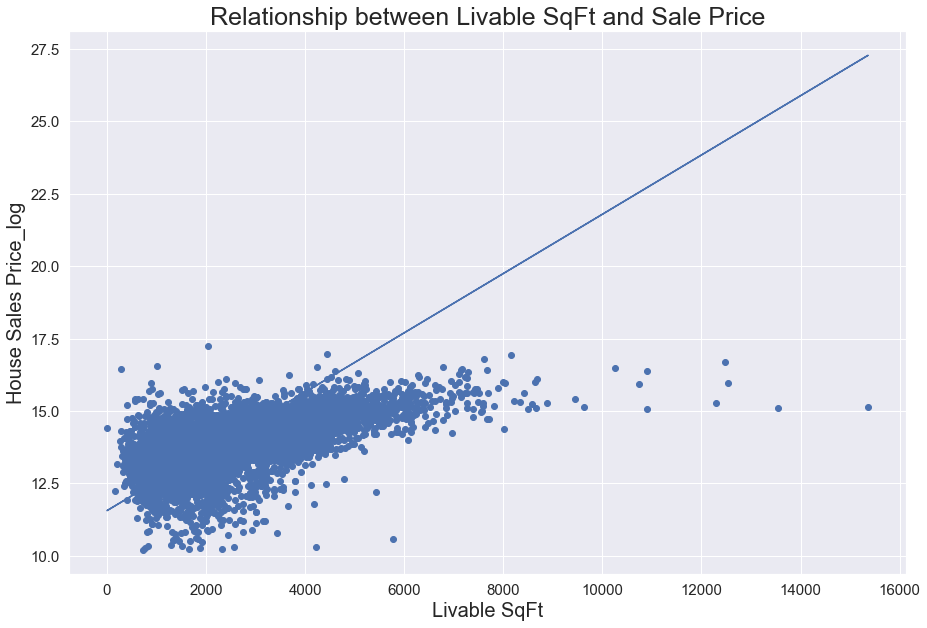

In [309]:
# defining abline in order to put line
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')



fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(cat_df['sqft_living'], np.log(cat_df['price']))

_y_ticks = [(value * 10**7) for value in range(0,4,1)]
ax.set(
    #yticks=_y_ticks,
    #yticklabels = [f'${int(x/1000000):,}M' for x in _y_ticks]
)
sqft = np.exp(0.0002)
#abline(sqft,13.74)

y = sqft* (scaled_df[2]) + 13.74
ax.plot(cat_df['sqft_living'], y)

plt.title("Relationship between Livable SqFt and Sale Price", fontsize=25)
plt.xlabel("Livable SqFt", fontsize=20)
plt.ylabel("House Sales Price_log", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('images/sqftliving_fig.png')
; 

In [ ]:
cat_df.describe()

## Grade visualization

In [261]:
#Graph for grade, groupby grade, median price

grade_df = pd.DataFrame(clean_houses.groupby('grade').median()['price'].sort_values())
grade_df.reset_index(inplace=True)
grade_df['stat_sig'] = [True,True,True,True,True,False,False,False,True,True,True,True]
grade_df
#[x for x in mlr_stats['stat_sig'] if grade_df['grade'] in mlr_stats['index']]


,grade,price,stat_sig
0,2 Substandard,302500.0,True
1,3 Poor,400000.0,True
2,4 Low,470000.0,True
3,5 Fair,500000.0,True
4,6 Low Average,575000.0,True
5,7 Average,750000.0,False
6,8 Good,950000.0,False
7,9 Better,1499950.0,False
8,10 Very Good,2180000.0,True
9,11 Excellent,2950000.0,True


''

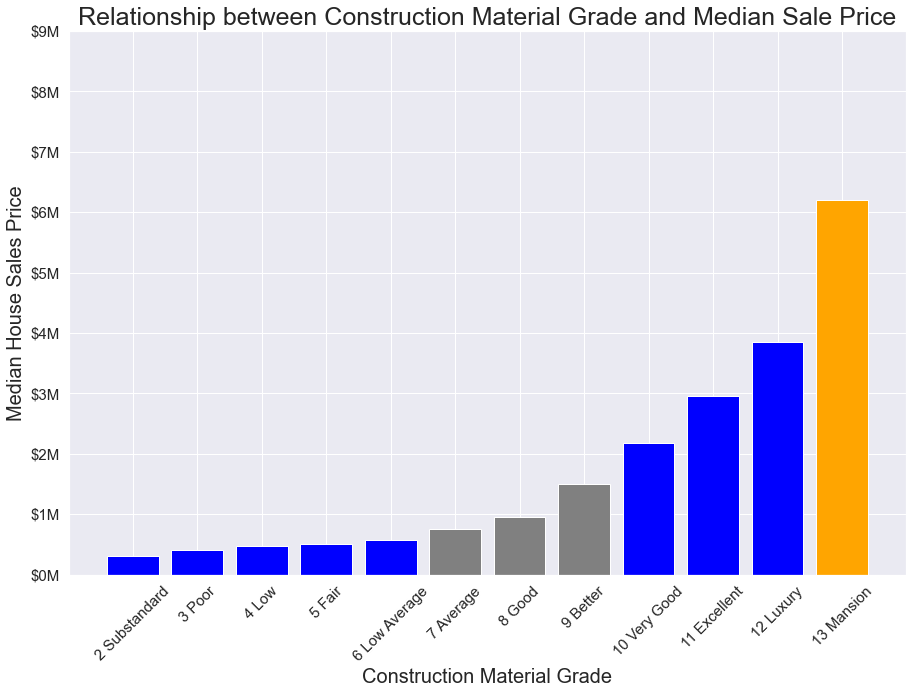

In [293]:
fig, ax = plt.subplots(figsize=(15,10))

colors = ['blue', 'blue', 'blue', 'blue', 'blue', 'grey', 'grey', 'grey', 'blue', 'blue', 'blue', 'orange']
#colors = ["orange" if i == True else "blue" for i in grade_df['stat_sig']]
ax.bar(x=grade_df['grade'],height=grade_df['price'], color=colors)
_y_ticks = [(value * 10**6) for value in range(0,10)]
ax.set(
    title = "Relationship between Construction Material Grade and Median Sale Price", 
    ylabel = "Median House Sales Price",
    xlabel = "Construction Material Grade",
    yticks=_y_ticks,
    yticklabels = [f'${int(x/1000000):,}M' for x in _y_ticks]
)
# ax.legend(['o', 'r', 'e'])

plt.title("Relationship between Construction Material Grade and Median Sale Price", fontsize=25)
plt.xlabel("Construction Material Grade", fontsize=20)
plt.ylabel("Median House Sales Price", fontsize=20)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)

plt.savefig('images/grade_fig.png')
;
#Add lines to make it visually easy to see pricing per grade, add theme at the beginning
# and see if there's a color code.

## Visualization for zipcodes

In [298]:
mlr_stats.sort_values(by='coef').head(10)

,index,coef,p_value,stat_sig
44,x44,-0.258091,3.009880e-226,True
32,x32,-0.228837,6.355755e-245,True
42,x42,-0.215454,4.213510e-181,True
19,x19,-0.213314,7.990473e-235,True
62,x62,-0.209329,2.553359e-231,True
54,x54,-0.198880,3.804357e-189,True
38,x38,-0.191556,6.894228e-219,True
21,x21,-0.184286,1.716967e-237,True
31,x31,-0.180302,5.778931e-220,True
90,x90,-0.174862,4.465446e-221,True


In [299]:
zip_df = pd.DataFrame(clean_houses.groupby(['zipcode','yr_sold']).median()['price'])
zip_df#.plt.bar() #== ['98422','98244','98288','98002','98047','98003','98023','98001','98092','98198']]

price
zipcode yr_sold          
98001   2021     575000.0
        2022     650000.0
98002   2021     455000.0
        2022     505000.0
98003   2021     540000.0
...                   ...
98663   2021     597450.0
99202   2021     759950.0
99203   2022     679950.0
99223   2022     879000.0
99403   2021     789995.0

[171 rows x 1 columns]

In [301]:
bot_zips = clean_houses.loc[clean_houses['zipcode'].isin(['98422','98224','98288','98002',
                                                          '98047','98003','98023','98001',
                                                          '98092','98198'])]

In [302]:
bot_zips

,id,price,bedrooms,bathrooms,sqft_living,view,grade,zipcode,yr_sold
8,2944500680,780000.0,4,2.5,2340,NONE,8 Good,98023,2022
13,3845100260,828000.0,4,3.0,3170,NONE,9 Better,98092,2021
14,1895460330,661000.0,4,2.5,2408,NONE,8 Good,98023,2021
39,1421059003,1680000.0,3,2.5,5200,NONE,10 Very Good,98092,2021
45,6053400345,315000.0,3,1.0,1150,NONE,7 Average,98002,2021
...,...,...,...,...,...,...,...,...,...
30124,1141400010,540000.0,3,2.5,1797,NONE,8 Good,98001,2021
30128,1761100480,560000.0,3,2.0,1480,NONE,7 Average,98023,2022
30134,4137070140,656500.0,3,2.5,2220,NONE,8 Good,98092,2021
30146,3915500105,380000.0,3,1.0,860,NONE,6 Low Average,98002,2021


In [303]:
zipcode_2021 = bot_zips.loc[clean_houses['yr_sold'] == 2021]
zipcode_2022 = bot_zips.loc[clean_houses['yr_sold'] == 2022]
grouped_2021 = pd.DataFrame(zipcode_2021.groupby(['zipcode']).median()['price'])
grouped_2022 = pd.DataFrame(zipcode_2022.groupby(['zipcode']).median()['price'])

In [296]:
x_ticks_2021 = np.array([0,1,2,3,4,5,6,7,8])
x_ticks_2022 = np.array([0,1,2,3,4,5,6,8,9])

''

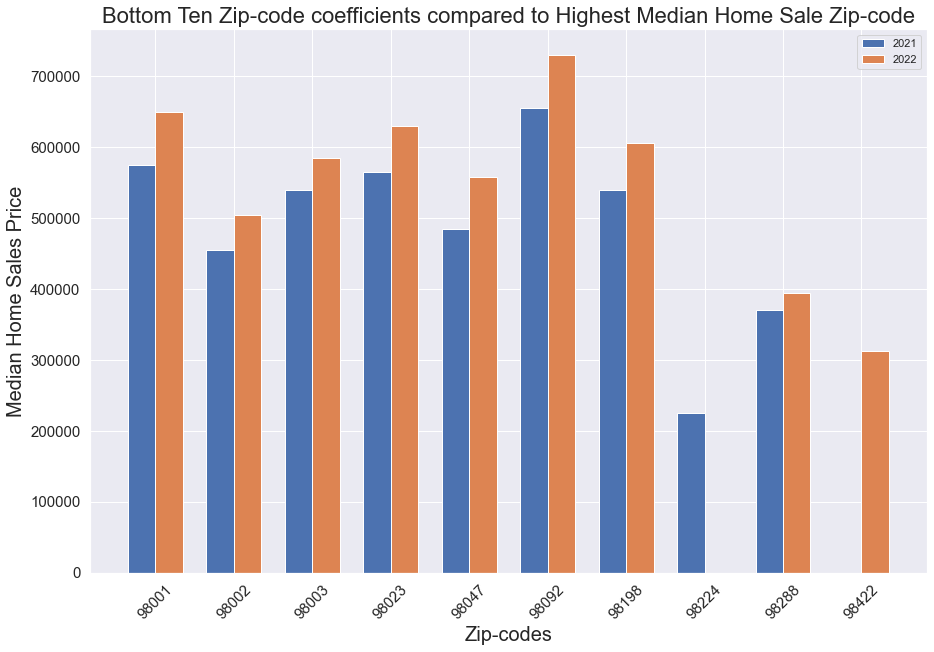

In [308]:

width = .35
fig, ax = plt.subplots(figsize=(15,10))

ax.set_title('Bottom Ten Zip-code coefficients compared to Highest Median Home Sale Zip-code', fontsize=22)

ax.bar(x=(x_ticks_2021-width/2),height=grouped_2021['price'], width = width)
ax.bar(x=(x_ticks_2022+width/2),height=grouped_2022['price'],width=width)


ax.set_xlabel('Zip-codes', fontsize=20)
ax.set_ylabel('Median Home Sales Price', fontsize=20)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(['98001', '98002', '98003', '98023', '98047', '98092', '98198','98224' ,'98288',
       '98422'], rotation =45, fontsize=15)
plt.yticks(fontsize=15)
ax.legend(["2021","2022"])

plt.savefig('images/zip_fig.png')
;

# Conclusion

In summary, our model predicted .... of variance in house prices. 